<a href="https://colab.research.google.com/github/wfwiggins/RSNA-Image-AI-2020/blob/master/RSNA20_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2020: Interactive AI for Non-coders**

## **Image Classification Basics for Beginners**

This work is adapted from Lakhani et al. "Hello World Deep Learning in Medical Imaging." Journal of Digital Imaging. 2018 Jun;31(3):283-289 ([link to article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5959832/)). Data were obtained and the notebook adapted from Paras Lakhani's GitHub repository ([link to repo](https://github.com/paras42/Hello_World_Deep_Learning/tree/9921a12c905c00a88898121d5dc538e3b524e520)). Code has been modified to match the format and directory structure from the article. Additional modifications have been made with the intent to increase readability and facilitate understanding for participants at all levels of coding skill and experience.

To explore this model and data set, please _Save a Copy in Drive_ from the `File` menu above (i.e. save a copy in your Google Drive).

# System Setup & Downloading the Data
For the experiments that follow, we'll use the [**Python** programming language](https://www.python.org/) with the [**fast.ai**](https://fast.ai/) API, built on top of the [**PyTorch**](https://pytorch.org/) **library**.

In [ ]:
#@title **Setting up the runtime environment...**
#@markdown Running this cell will install the necessary libraries, download the data and restart the session.
#@markdown This will generate an error message, which we can safely ignore.

import os

!pip install fastai --upgrade >/dev/null

# **Downloading the data...**

!wget -q https://github.com/wfwiggins/RSNA-Image-AI-2020/blob/master/data.zip?raw=true
!mkdir -p data
!unzip -o data.zip?raw=true -d data >/dev/null
!rm data.zip?raw=true

os.kill(os.getpid(), 9)

# Taking a look at the data
Let's take a look at the directory structure and contents, then create some variables to help us as we proceed.

In [1]:
#@title Directory structure

from fastai.basics import *
from fastai.vision.all import *

# Set path variable to the directory where the data is located
path = Path('/content/data')

# Command line "magic" command to show directory contents
!ls {path}/*/*


/content/data/test/abd:
abd_test.png

/content/data/test/chst:
chest_test.png

/content/data/train/abd:
abd0.png   abd14.png  abd19.png  abd23.png  abd28.png  abd3.png  abd8.png
abd10.png  abd15.png  abd1.png	 abd24.png  abd29.png  abd4.png  abd9.png
abd11.png  abd16.png  abd20.png  abd25.png  abd2.png   abd5.png
abd12.png  abd17.png  abd21.png  abd26.png  abd30.png  abd6.png
abd13.png  abd18.png  abd22.png  abd27.png  abd31.png  abd7.png

/content/data/train/chst:
chst33.png  chst39.png	chst45.png  chst51.png	chst57.png  chst63.png
chst34.png  chst40.png	chst46.png  chst52.png	chst58.png  chst64.png
chst35.png  chst41.png	chst47.png  chst53.png	chst59.png  chst65.png
chst36.png  chst42.png	chst48.png  chst54.png	chst60.png
chst37.png  chst43.png	chst49.png  chst55.png	chst61.png
chst38.png  chst44.png	chst50.png  chst56.png	chst62.png

/content/data/val/abd:
abd0.png  abd1.png  abd2.png  abd3.png	abd4.png

/content/data/val/chst:
abd0.png  abd1.png  abd2.png  abd3.png	abd4.png


/usr/local/lib/python3.6/dist-packages/fastcore/foundation.py:54: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


As you can see, the `data` directory contains subdirectories `train`, `val` and `test`, which contain the *training*, *validation* and *test* data for our experiment. `train` and `val` contain subdirectories `abd` and `chst` containing abdominal and chest radiographs for each data set. There are 65 training images and 10 validation images with *balanced distributions* over our *target classes* (i.e. approximately equal numbers of abdominal and chest radiographs in each data set).

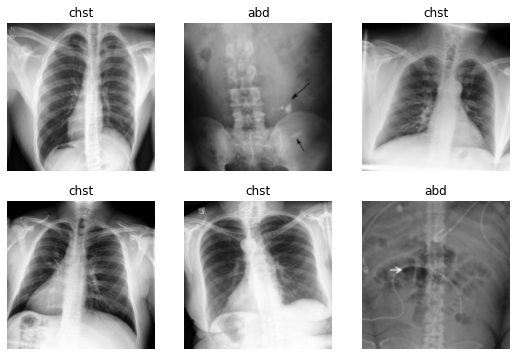

In [2]:
#@title Load the image data into DataLoaders

dls = ImageDataLoaders.from_folder(path, valid='val', seed=42, item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75), bs=16)
dls.show_batch(max_n=6)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=6.918309736647643e-06)

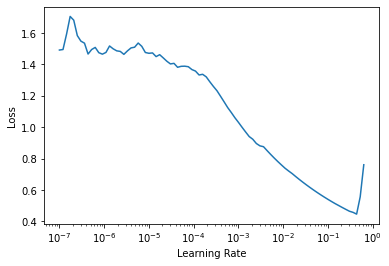

In [3]:
#@title Find the optimal learning rate

learn = cnn_learner(dls, resnet18, metrics=accuracy, seed=42)
learn.lr_find()

In [4]:
#@title Fine-tune the model

learn.fine_tune(5, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.004786,0.234783,0.900000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.128279,0.051644,1.000000,00:01
1,0.070469,0.021422,1.000000,00:01
2,0.049928,0.014123,1.000000,00:01
3,0.036216,0.013178,1.000000,00:01
4,0.027898,0.016933,1.000000,00:01


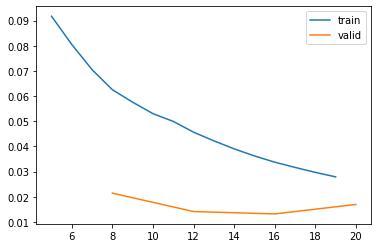

In [5]:
#@title Plot training curves

learn.recorder.plot_loss()

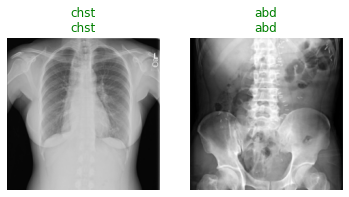

In [6]:
#@title Test the model on the test dataset

# !mkdir data/test/abd
# !mkdir data/test/chst
# !mv data/test/abd_test.png data/test/abd
# !mv data/test/chest_test.png data/test/chst

test_files = get_image_files(path/'test')
test_dl = learn.dls.test_dl(test_files, with_labels=True)
learn.show_results(dl=test_dl)

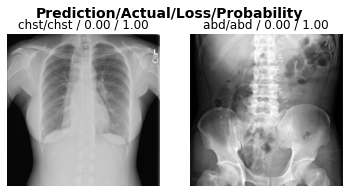

In [7]:
#@title Get more information

interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_top_losses(k=2)

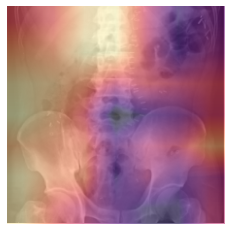

In [43]:
#@title Class activation maps (CAM)
classification = 'abd' #@param ['abd', 'chest']

label = 'abd' if classification == 'abd' else 'chst'

y = get_image_files(path/'test'/label)
test_dl = learn.dls.test_dl(y, with_labels=True)

hook = hook_output(learn.model[0])
x, _ = first(test_dl)
with torch.no_grad(): output = learn.model.eval()(x)
act = hook.stored[0]
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');
hook.remove()

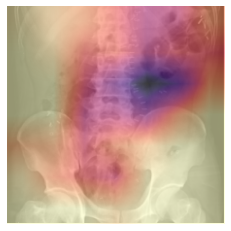

In [42]:
#@title Grad-CAM

classification = 'abd' #@param ['abd', 'chest'] 
cls = 0 if classification == 'abd' else 1
label = 'abd' if classification == 'abd' else 'chst'

y = get_image_files(path/'test'/label)
test_dl = learn.dls.test_dl(y, with_labels=True)
x, _ = first(test_dl)
mod = learn.model[0]

layer = -1 #@param {type: "slider", min: -8, max: -1, step: 1}

hook_func = lambda m,i,o: o[0].detach().clone()

with Hook(mod[layer], hook_func, is_forward=False) as hookg:
    with Hook(mod[layer], hook_func) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0, cls].backward()
    grad = hookg.stored

w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');